In [6]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import ipywidgets as widgets
plt.style.use(plt.style.available[20])
plt.style.use("https://github.com/comp-neural-circuits/intro-to-comp-neuro/raw/dev/plots_style.txt")

%matplotlib inline

# The 4 equations of the Hodgkin-Huxley model  

($V$: Membrane Potential)

* $C_M\displaystyle \frac{dV}{dt}=-g_{Na}\;\;(V-V_{Na})-g_k\;\;(V-V_K)-g_l\;\;(V-V_l)+I$   


($h$: Na Inactivation)  

* $\displaystyle \frac{dh}{dt}=\alpha_h{(V)}\;\;(1-h)-\beta_h(V)h$ 


($m$: Na Activation) 

* $\displaystyle \frac{dm}{dt}=\alpha_m{(V)}\;\;(1-m)-\beta_m(V)m$ 


($n$: K Activation)  

* $\displaystyle \frac{dn}{dt}=\alpha_n{(V)}\;\;(1-n)-\beta_n(V)n$ 

In [ ]:
class HodgkinHuxleyNeuron(object):
    """The first version of our LIF neuron class that can initiate a single neuron, 
    run the simulation for a certain number of steps while keeping track of the membrane voltage
    and plot the results of the run
    """
    def __init__(self, 
                 tau_m = 10, v_start = -50, el = -75, r_m = 100e6, v_reset = -70, v_th = -50, I_e = 10e-8, dt = 0.1):
        '''This function is executed when we create an object from that class'''
        super(HodgkinHuxleyNeuron, self).__init__()

        ### assign the attributes of the class
        self.tau_m = tau_m  # membrane time constant
        self.el = el # leak reversal potential

        self.r_m = r_m # membrane resistance
        self.v_reset = v_reset # reset voltage after a spike
        self.v_th = v_th # threshold voltage
        self.I_e = I_e # Input current


        self.v = v_start # starting voltage value for the simulation
        self.dt = dt # simulation timestep    


        ### Initiate the recording lists
        self.v_list = [v_start]
        self.t_list = [0]



    def timestep(self):
        '''
            This function performs an update step of the membrane voltage evolution
            we use forward euler
        '''
        if self.v <= self.v_th:
            dv_dt = (-self.v + self.el + self.r_m * self.I_e)/self.tau_m
            self.v += dv_dt * self.dt
        else:
            self.v = self.v_reset


    def run_simulation(self, time_steps = 100):
        '''
            Function to run the simulation for a fixed number of time steps (time_steps)
        '''

        for ii in range(time_steps):
            self.timestep()

            self.v_list.append(self.v)
            current_time = self.t_list[-1] + self.dt
            self.t_list.append(current_time) 

    def plot_traces(self):
        '''
            Function to plot the simulated results
            creates a figure and plots the voltage traces vs. the simulated time
        '''

        plt.figure()
        plt.title('Time evolution of membrane voltage')

        plt.plot(self.t_list,self.v_list,linewidth=2.5)

        plt.xlabel('Time in ms')
        plt.ylabel('Voltage in mV')

        plt.ylim([-80,20])

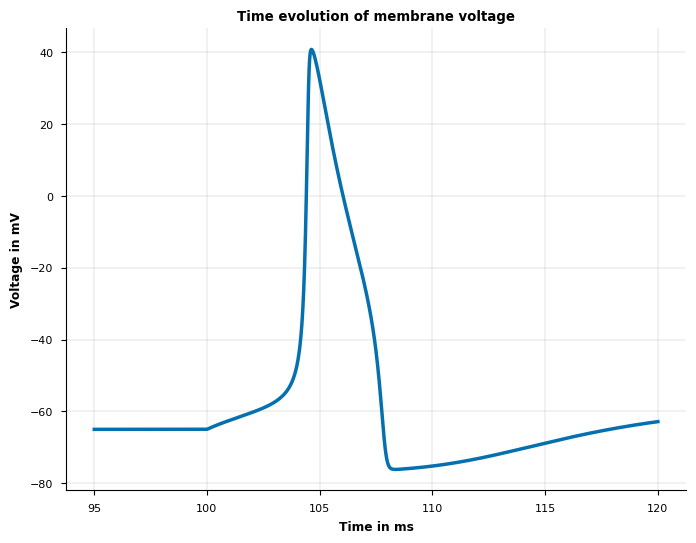

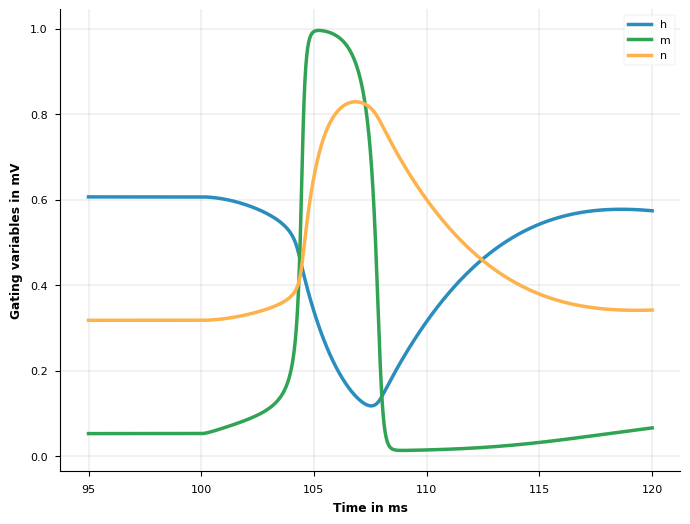

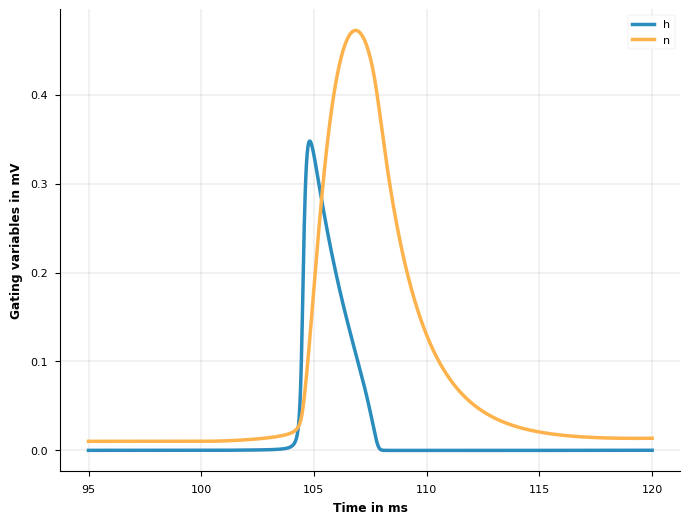

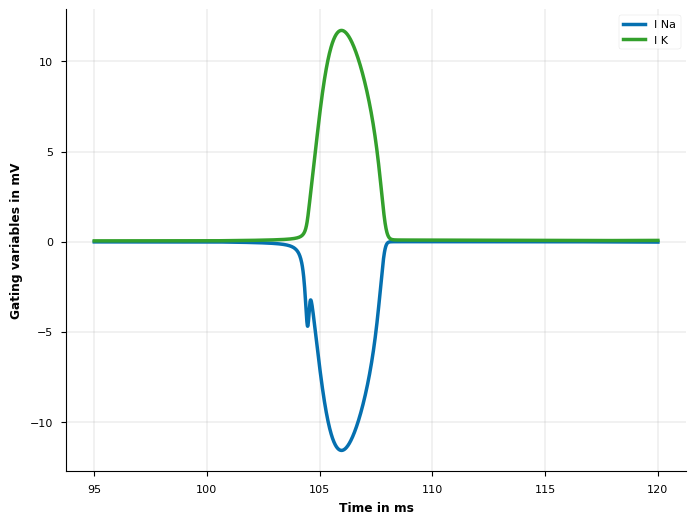

In [110]:
class HodgkinHuxleyNeuron(object):
    """A class to model the Hodgkin Huxley formalism for a spiking neuron
       The methods allow to run the simulation and plot the results
    """
    def __init__(self, 
                 g_na=1.2, # mS/mm2
                 g_k=0.36, # mS/mm2
                 g_l=0.003, # mS/mm2
                 e_na = 50, # mV
                 e_k  = -77, # mV
                 e_l  = -54.4, # mV
                 c_m = 0.01, # micro F/mm2
                 i_e = 0, # mu A /mm2
                 dt = 0.01, # ms
                ):
        '''This function is executed when we create an object from that class'''
        super(HodgkinHuxleyNeuron, self).__init__()

        ### assign the attributes of the class   
              
        self.v = -60 # starting voltage value for the simulation
        self.dt = dt # simulation timestep    

        # maximum conductances
        self.g_na = g_na #g_na 
        self.g_k = g_k # g_k
        self.g_l = g_l # g_l
        
        # reveral potentials
        self.e_na = e_na # e_na
        self.e_k  = e_k # e_k
        self.e_l  = e_l # e_l
        
        # membrane capacitance
        self.c_m = c_m
        
        self.i_e = i_e # Input current
        
        
        
        ### Initiate the recording lists
        self.v_list = [self.v]
        self.t_list = [0]
        
        # initialize the gating parameters
        self.h = 0
        self.m = 0
        self.n = 0.5
        
        self.m_list = [self.m]
        self.n_list = [self.n]
        self.h_list = [self.h]
        
        self.i_na_list = [0]
        self.i_k_list = [0]


    def dv(self):    
        i_na = self.g_na * self.h * (self.m**3) * (self.v - self.e_na)
        i_k = self.g_k * (self.n**4) * (self.v - self.e_k)
        i_l = self.g_l * (self.v - self.e_l)
        
        self.i_k_list.append(i_k)
        self.i_na_list.append(i_na)
        dv = (- i_na - i_k - i_l + self.i_e) * self.dt / self.c_m
        
        return dv

    def dh(self):
        alpha_h = 0.07 * np.exp(-0.05*(self.v + 65))
        beta_h  = 1. / (1 + np.exp(-0.1*(self.v + 35)) + 1)
        dh = (alpha_h * (1 - self.h) - beta_h * self.h) * self.dt
        
        return dh

    def dm(self):
        alpha_m = 0.1 * (self.v + 40) / (1 - np.exp(-0.1*(self.v + 40)))
        beta_m  = 4. * np.exp(-0.0556*(self.v + 65))
        dm = (alpha_m * (1 - self.m) - beta_m * self.m) * self.dt
        
        return dm

    def dn(self):
        alpha_n = 0.01 * (self.v + 55) / (1-np.exp(-0.1*(self.v+55)))
        beta_n  = 0.125 * np.exp(-0.0125*(self.v + 65))
        dn = (alpha_n * (1 - self.n) - beta_n * self.n) * self.dt
        
        return dn

    def timestep(self):
        '''
            This function performs an update step of the membrane voltage evolution
            we use forward euler
        '''
        self.v += self.dv()
        self.h += self.dh()
        self.m += self.dm()
        self.n += self.dn()


    def run_simulation(self, time_steps = 100):
        '''
            Function to run the simulation for a fixed number of time steps (time_steps)
        '''

        for ii in range(time_steps):
            self.timestep()

            self.v_list.append(self.v)
            self.h_list.append(self.h)
            self.m_list.append(self.m)
            self.n_list.append(self.n)
            current_time = self.t_list[-1] + self.dt
            self.t_list.append(current_time) 

    def plot_traces(self):
        '''
            Function to plot the simulated results
            creates a figure and plots the voltage traces vs. the simulated time
        '''

        plt.figure()
        plt.title('Time evolution of membrane voltage')
    
        show_from = 9500
        
    
    
        plt.plot(self.t_list[show_from:],self.v_list[show_from:],linewidth=2.5)
        

        plt.xlabel('Time in ms')
        plt.ylabel('Voltage in mV')
            
        plt.figure()
        
        
        plt.plot(self.t_list[show_from:],self.h_list[show_from:],linewidth=2.5, label= 'h', c='#2b8cbe')
        plt.plot(self.t_list[show_from:],self.m_list[show_from:],linewidth=2.5, label= 'm', c ='#31a354')
        plt.plot(self.t_list[show_from:],self.n_list[show_from:],linewidth=2.5, label= 'n', c ='#feb24c' )
        plt.xlabel('Time in ms')
        plt.ylabel('Gating variables in mV')
        plt.legend()
        
        plt.figure()
        
        
        plt.plot(self.t_list[show_from:],np.asarray(self.m_list[show_from:])**3*np.asarray(self.h_list[show_from:]),linewidth=2.5, label= 'h', c='#2b8cbe')
        plt.plot(self.t_list[show_from:],np.asarray(self.n_list[show_from:])**4,linewidth=2.5, label= 'n', c ='#feb24c' )
        plt.xlabel('Time in ms')
        plt.ylabel('Gating variables in mV')
        plt.legend()
        
        plt.figure()
        
        
        plt.plot(self.t_list[show_from:],self.i_na_list[show_from:],linewidth=2.5, label= 'I Na')
        plt.plot(self.t_list[show_from:],self.i_k_list[show_from:],linewidth=2.5, label= 'I K')
        plt.xlabel('Time in ms')
        plt.ylabel('Gating variables in mV')
        plt.legend()

#         plt.ylim([-80,40])
        
        
model = HodgkinHuxleyNeuron()
model.run_simulation(10000)
model.i_e = 0.03
model.run_simulation(2000)
model.plot_traces()

In [7]:
def dv(v, param, dt, par_dict):
    
    C_m = par_dict['C_m']
    G_Na = par_dict['G_Na']
    G_K = par_dict['G_K']
    G_L = par_dict['G_L']
    E_Na = par_dict['E_Na']
    E_K = par_dict['E_K']
    E_L = par_dict['E_L']
    
    
    
    
    h, m, n, i = param
    gna = G_Na * h * (m**3)
    gk = G_K * (n**4)
    gl = G_L
    ina = gna * (v - E_Na)
    ik = gk * (v - E_K)
    il = gl * (v - E_L)
    return (- ina - ik - il + i) * dt / C_m

def dh(h, param, dt, par_dict):
    v = param
    alph = 0.07 * np.exp(-v / 20)
    beth = 1. / (np.exp((30 - v) / 10) + 1)
    return (alph * (1 - h) - beth * h) * dt

def dm(m, param, dt, par_dict):
    v = param
    alpm = 0.1 * (25 - v) / (np.exp((25 - v) / 10) - 1)
    betm = 4. * np.exp(-v / 18)
    return (alpm * (1 - m) - betm * m) * dt

def dn(n, param, dt, par_dict):
    v = param
    alpn = 0.01 * (10 - v) / (np.exp((10 - v) / 10) - 1)
    betn = 0.125 * np.exp(-v / 80)
    return (alpn * (1 - n) - betn * n) * dt

In [8]:
def rk4(f, y, param, dt, par_dict):
    k1 = f(y, param, dt, par_dict)
    k2 = f(y + dt * k1 * 0.5, param, dt, par_dict)
    k3 = f(y + dt * k2 * 0.5, param, dt, par_dict)
    k4 = f(y + dt * k3, param, dt, par_dict)
    
    return k1
    return (k1 + 2*k2 + 2*k3 + k4) / 6

def update(v, m, h, n, i, dt, par_dict):
    v += rk4(dv, v, (h, m, n, i), dt, par_dict)
    m += rk4(dm, m, v, dt, par_dict)
    h += rk4(dh, h, v, dt, par_dict)
    n += rk4(dn, n, v, dt, par_dict)
    return v, m, h, n

In [9]:
def run_simulation(
    ### simulation parameters ###
   
    dt = 0.01,      # time step (ms)
    T = 55,       # total running time (ms)
    
    
    ### model paramters ###
    C_m = 1.,       # membrane capacitance (micro F/cm**2)
    
    # Sodium Channel
    G_Na = 120.,    # max Na conductance (mS/cm**2)
    E_Na = 115.,    # Na reversal potential (mV)
    
    # Kalium Channel
    G_K = 40.,      # max K conductance (mS/cm**2)
    E_K = -12.0,    # K reversal potential (mV)
    
    # Leak current    
    G_L = 0.24,     # max leak onductance (mS/cm**2)
    E_L = 10.613,   # leak potential (mV)
    
    flag = 'spike'
    ):
    
    par_dict = dict(
    C_m = C_m,
    G_Na = G_Na,
    E_Na = E_Na,
    G_K  = G_K,
    E_K  = E_K,
    G_L  = G_L,
    E_L  = E_L,
    )
    # initialize the simulation parameters
    V_m = 0 # membrane potential (mV)
    m_Na = 0 # Na channel activation (dimensionless)
    h_Na = 0 # Na channel inactivation (dimensionless)
    n_K = 0 # K channel activation (dimensionless)

    # total membrane current (microA/cm**2) for the time of the simulation
   
    I_input = np.array([0] * int(T/dt))
    if flag == 'spike':
        I_input[1500:1800] = 10
    if flag == 'burst':
        I_input[1500:] = 10
    if flag == 'refractory':
        for ii in [1500,2100,2700]:
         I_input[ii:ii + 300] = 10
    Time = [ii*dt for ii in range(int(T/dt))]


    result_V_m, result_m_Na, result_h_Na, result_n_K = ([] for i in range(4))
    for t in range(int(100 // dt)):
        V_m, m_Na, h_Na, n_K = update(v=V_m, m=m_Na, h=h_Na, n=n_K, i=0, dt=dt, par_dict = par_dict)
    for t in range(len(I_input)):
        V_m, m_Na, h_Na, n_K = update(v=V_m, m=m_Na, h=h_Na, n=n_K, i=I_input[t], dt=dt, par_dict = par_dict)
        result_V_m.append(V_m)
        result_m_Na.append(m_Na)
        result_h_Na.append(h_Na)
        result_n_K.append(n_K)
    return result_V_m, result_m_Na, result_h_Na, result_n_K, I_input, Time

In [10]:
def plot_current(Time, Current):
    plt.subplots(figsize = [12,5])
    plt.xlabel('$t$ (ms)')
    plt.ylabel('$I$ $\mathrm{(\mu A/cm^2)}$')
    # plt.xlim(-1, 30)
    plt.ylim(-2, 12)
    plt.plot(Time, Current)
    plt.title('Input Current $I$')
    
def plot_membrane_potential(Time, Voltage):

    plt.subplots(figsize = [12,5])
    plt.xlabel('$t$ (ms)')
    plt.ylabel('$V$ (mV)')
    plt.ylim(-20, 120)
    plt.plot(Time, Voltage, color = '#bd0026')
    title = plt.title('Membrane Potential $V$')

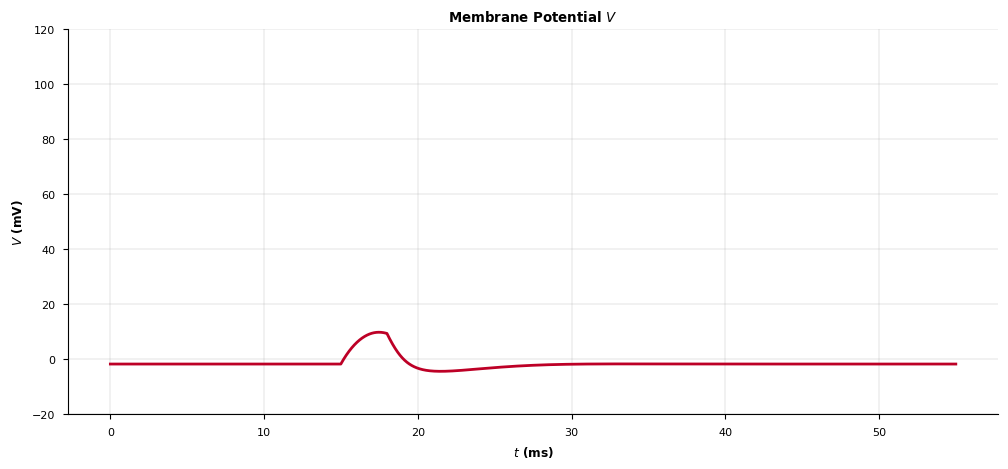

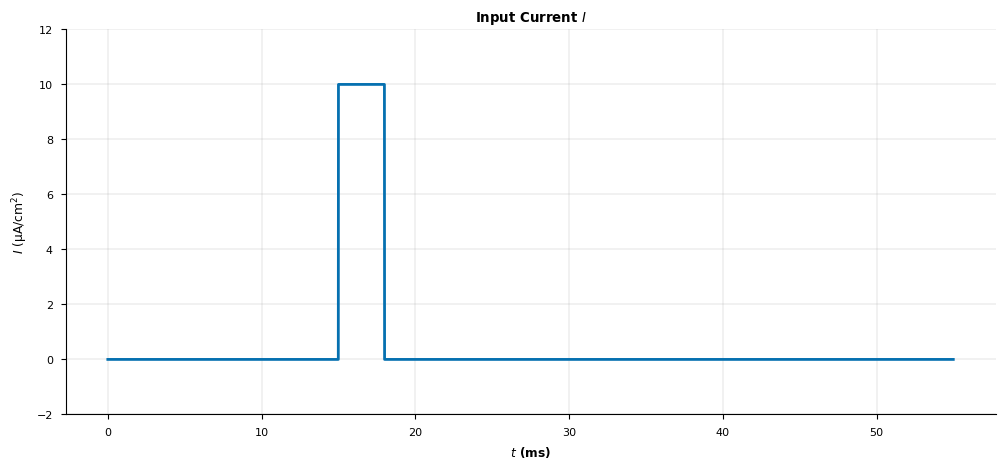

In [11]:
Voltage,m,h,n,I,Time = run_simulation(
### simulation parameters ###
   
    dt = 0.01,      # time step (ms)
    T = 55,       # total running time (ms)
    
    
    ### model paramters ###
    C_m = 1.,       # membrane capacitance (micro F/cm**2)
    
    # Sodium Channel
    G_Na = 10,    # max Na conductance (mS/cm**2)
    E_Na = 115.,    # Na reversal potential (mV)
    
    # Kalium Channel
    G_K = 40.,      # max K conductance (mS/cm**2)
    E_K = -12.0,    # K reversal potential (mV)
    
    # Leak current    
    G_L = 0.24,     # max leak onductance (mS/cm**2)
    E_L = 10.613,   # leak potential (mV)
    
    flag = 'spike'
)

plot_membrane_potential(Time = Time, Voltage = Voltage)
plot_current(Time = Time, Current = I)

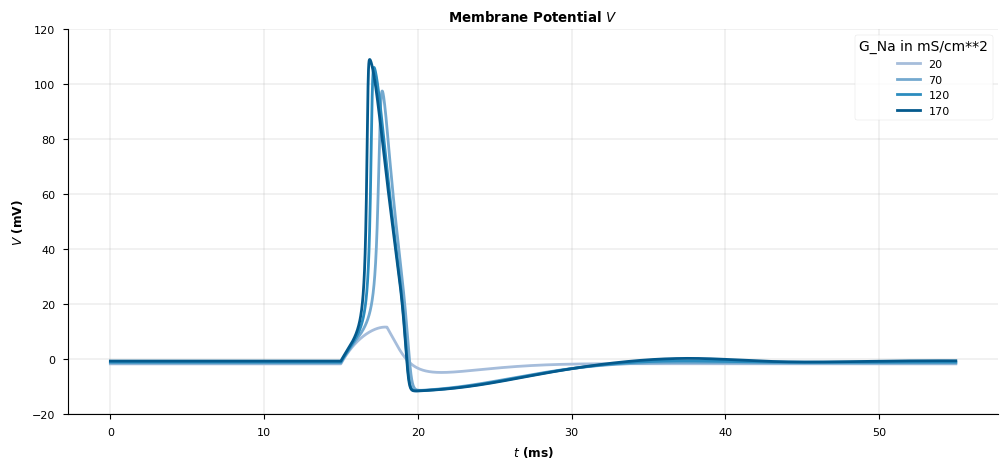

In [12]:
fig, ax = plt.subplots(figsize = [12,5])
colors = ['#a6bddb','#74a9cf','#2b8cbe','#045a8d']
for color, G_Na in zip(colors,[20,70, 120, 170]):
    V_membrane,_,_,_,_,Time = run_simulation(G_Na = G_Na)
    ax.plot(Time, V_membrane, color = color, label = f"{G_Na}")
    
    
ax.set_xlabel('$t$ (ms)')
ax.set_ylabel('$V$ (mV)')
ax.set_ylim(-20, 120)
title = plt.title('Membrane Potential $V$')
ax.legend(title = "G_Na in mS/cm**2" )

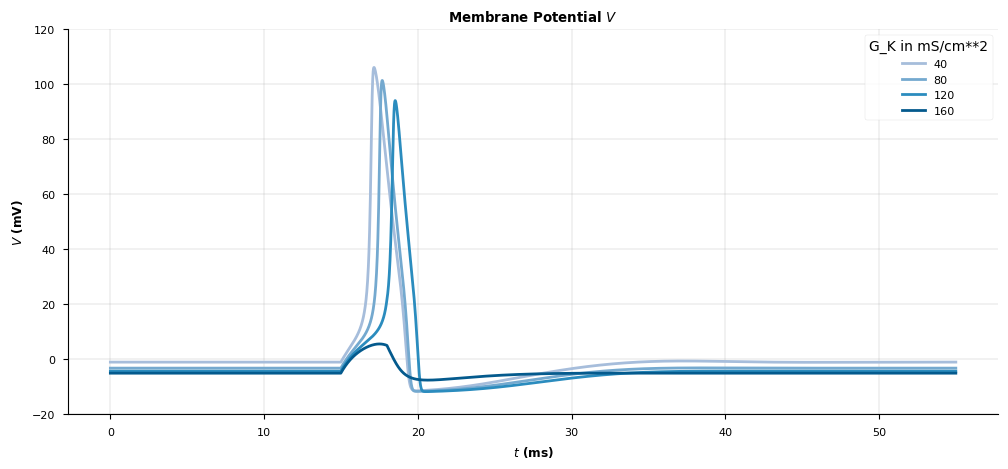

In [13]:
fig, ax = plt.subplots(figsize = [12,5])
colors = ['#a6bddb','#74a9cf','#2b8cbe','#045a8d']
for color, G_K in zip(colors,[40,80, 120, 160]):
    V_membrane,_,_,_,_,Time = run_simulation(G_K = G_K)
    ax.plot(Time, V_membrane, color = color, label = f"{G_K}")
    
    
ax.set_xlabel('$t$ (ms)')
ax.set_ylabel('$V$ (mV)')
ax.set_ylim(-20, 120)
title = plt.title('Membrane Potential $V$')
ax.legend(title = "G_K in mS/cm**2" )

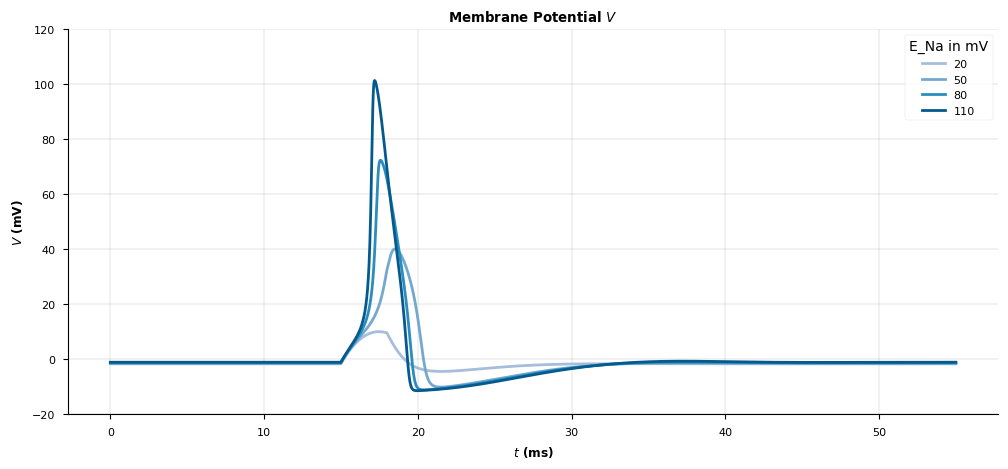

In [14]:
fig, ax = plt.subplots(figsize = [12,5])
colors = ['#a6bddb','#74a9cf','#2b8cbe','#045a8d']
for color, E_Na in zip(colors,[20,50, 80, 110]):
    V_membrane,_,_,_,_,Time = run_simulation(E_Na = E_Na)
    ax.plot(Time, V_membrane, color = color, label = f"{E_Na}")
    
    
ax.set_xlabel('$t$ (ms)')
ax.set_ylabel('$V$ (mV)')
ax.set_ylim(-20, 120)
title = plt.title('Membrane Potential $V$')
ax.legend(title = "E_Na in mV" )

Text(0.5, 1.0, 'Ion Channel Activation')

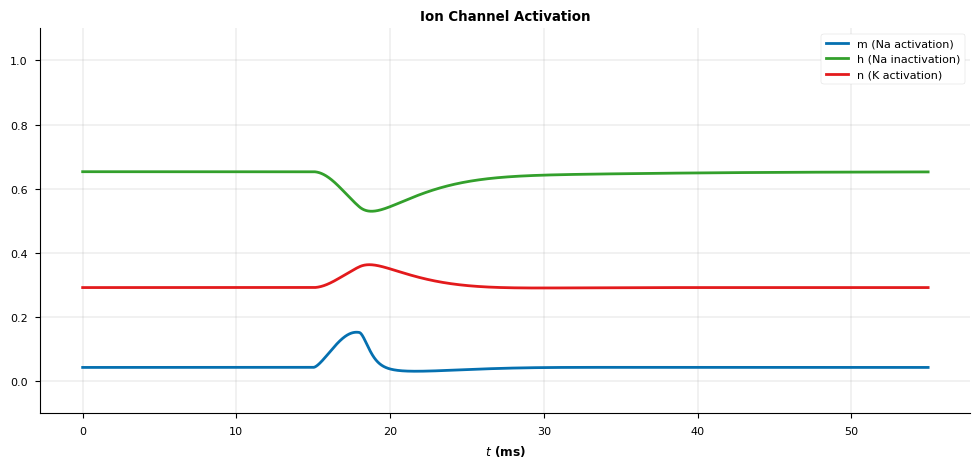

In [15]:
fig, ax = plt.subplots(figsize = [12,5])
plt.xlabel('$t$ (ms)')
plt.ylim(-0.1, 1.1)
plt.plot(Time, m)
plt.plot(Time, h)
plt.plot(Time, n)
plt.legend(['m (Na activation)', 'h (Na inactivation)',
            'n (K activation)'], bbox_to_anchor=(1, 1), framealpha=1)
plt.title('Ion Channel Activation')

## Refractory Period

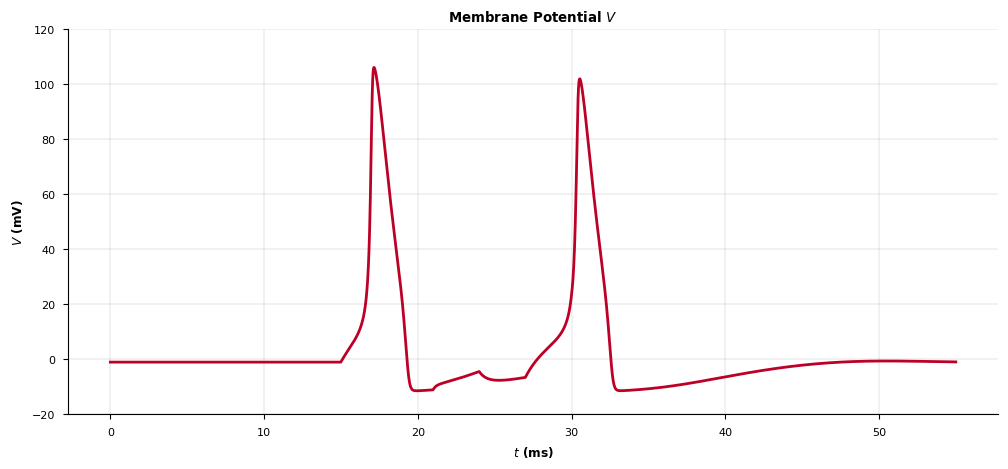

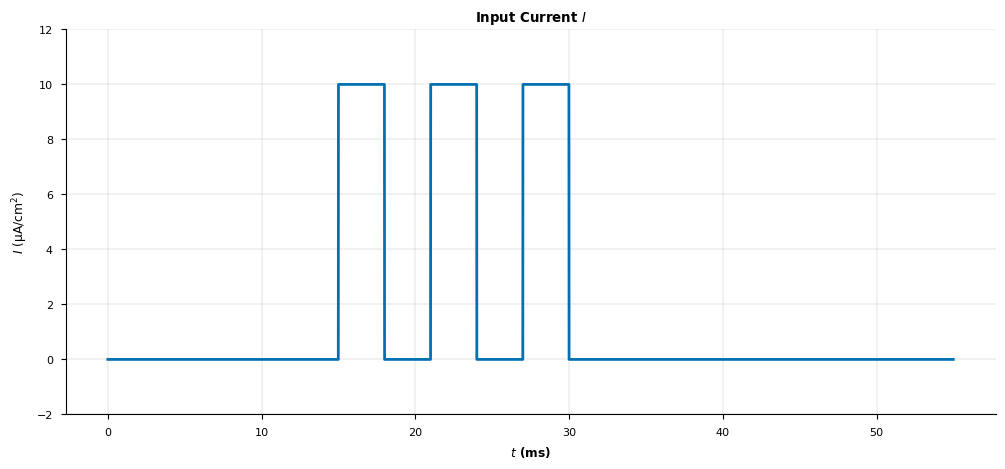

In [16]:
Voltage_refractory,m_refractory,h_refractory,n_refractory,I_refractory,Time_refractory = run_simulation(
    flag = 'refractory'
)

plot_membrane_potential(Time = Time_refractory, Voltage = Voltage_refractory)
plot_current(Time = Time_refractory, Current = I_refractory)

Text(0.5, 1.0, 'Ion Channel Activation')

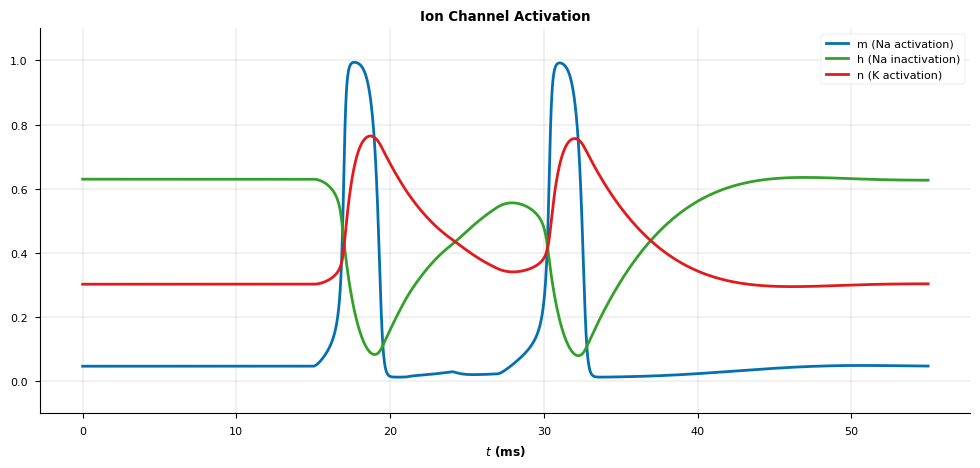

In [17]:
fig, ax = plt.subplots(figsize = [12,5])
plt.xlabel('$t$ (ms)')
plt.ylim(-0.1, 1.1)
plt.plot(Time_refractory, m_refractory)
plt.plot(Time_refractory, h_refractory)
plt.plot(Time_refractory, n_refractory)
plt.legend(['m (Na activation)', 'h (Na inactivation)',
            'n (K activation)'], bbox_to_anchor=(1, 1), framealpha=1)
plt.title('Ion Channel Activation')

## Bursting

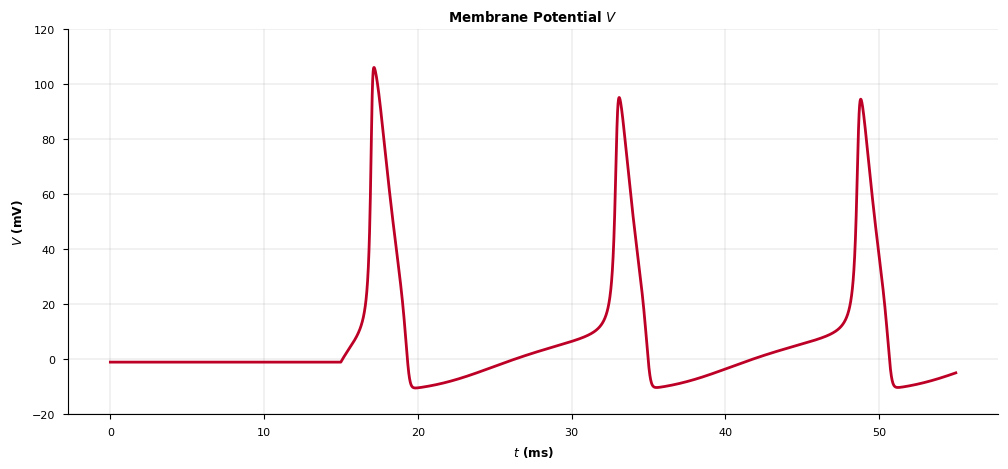

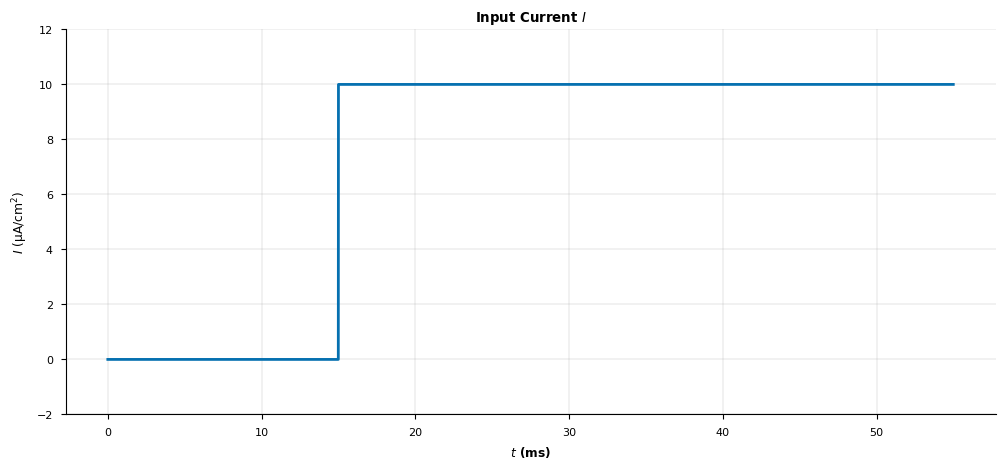

In [18]:
Voltage_burst,m_burst,h_burst,n_burst,I_burst,Time_burst = run_simulation(flag = 'burst')

plot_membrane_potential(Time = Time_burst, Voltage = Voltage_burst)
plot_current(Time = Time_burst, Current = I_burst)

Text(0.5, 1.0, 'Ion Channel Activation')

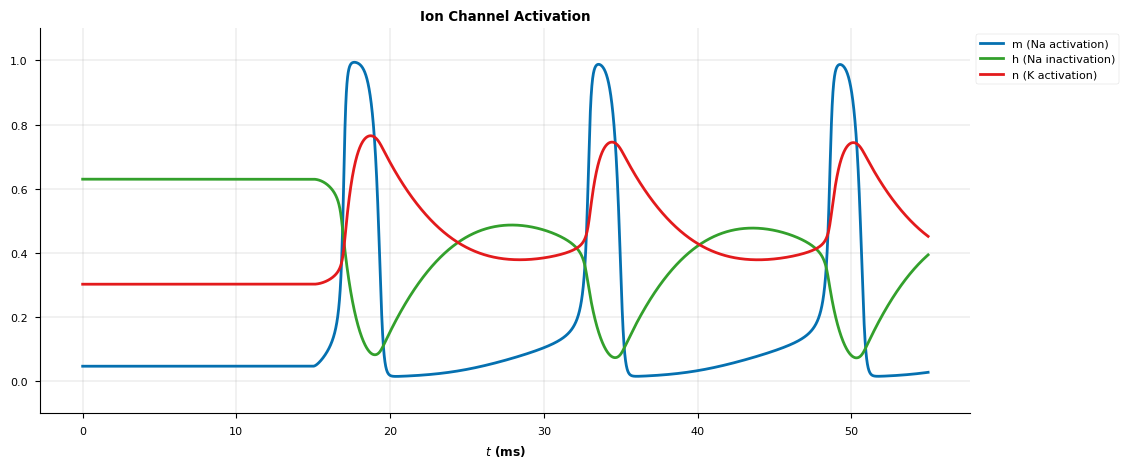

In [19]:
fig, ax = plt.subplots(figsize = [12,5])
plt.xlabel('$t$ (ms)')
plt.ylim(-0.1, 1.1)
plt.plot(Time_burst, m_burst)
plt.plot(Time_burst, h_burst)
plt.plot(Time_burst, n_burst)
plt.legend(['m (Na activation)', 'h (Na inactivation)',
            'n (K activation)'], bbox_to_anchor=(1, 1), framealpha=1)
plt.title('Ion Channel Activation')